In [4]:
## importing the dependencies 
import os 
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Conv2DTranspose,Reshape,Input
from tensorflow.keras.models import Model 
from tensorflow.keras import backend as backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import random

In [5]:
path="E:/dogs and cats"
names=os.listdir(path)
names

['cats', 'dogs', 'fishes']

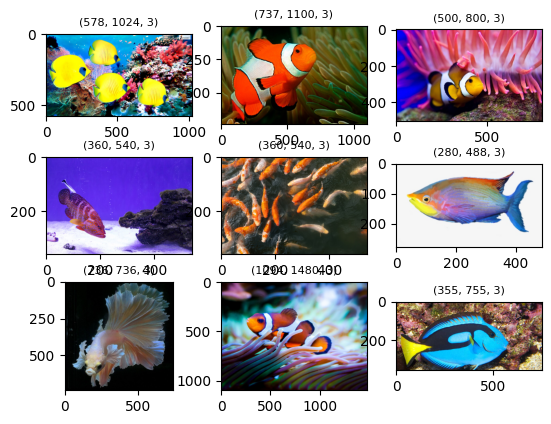

In [6]:
font3 = {'size':8}
for name in names:
    img_path=os.path.join(path,name)
    for idx,img in enumerate(os.listdir(img_path)[0:9],start=1):
        img_array=cv2.imread(os.path.join(img_path,img))
        img_array=cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
        plt.subplot(3,3,idx)
        plt.title(img_array.shape,fontdict=font3)
        plt.imshow(img_array)
        plt.show
         

In [7]:
font3 = {'size':8}
training_set=[]
img_size=256
img_size=256
for name in names:
    img_path=os.path.join(path,name)
    for img in os.listdir(img_path):
        img_array=cv2.imread(os.path.join(img_path,img))
        img_array=cv2.resize(img_array,(img_size,img_size))
        training_set.append(img_array)

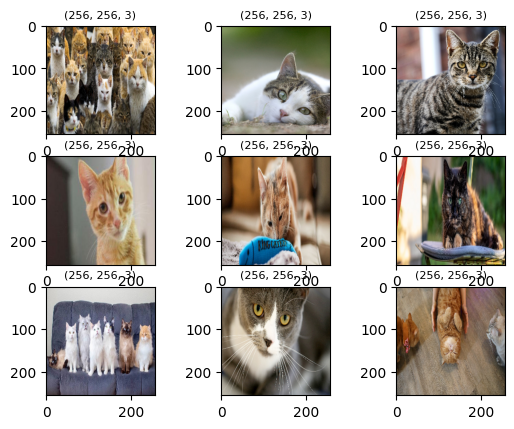

In [8]:
for idx,img_array in enumerate(training_set[0:9],start=1):
        img_array=cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
        plt.subplot(3,3,idx)
        plt.title(img_array.shape,fontdict=font3)
        plt.imshow(img_array)
        plt.show

In [9]:
def decolor(img):
    """
    grayscale = 0.299*red + 0.587*green + 0.114*blue
    """
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

In [10]:
new_training_set=[]
for img in training_set:
    new_training_set.append(decolor(img))

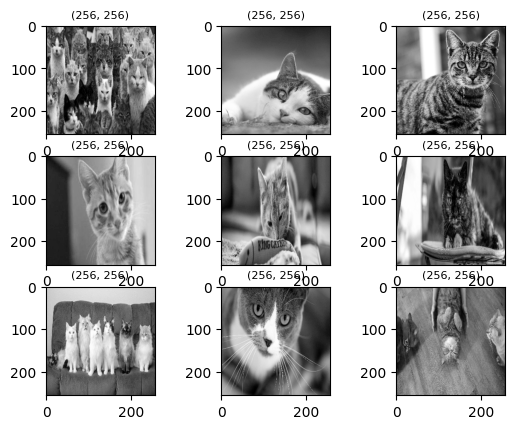

In [11]:
for idx,img_array in enumerate(new_training_set[0:9],start=1):
        plt.subplot(3,3,idx)
        plt.title(img_array.shape,fontdict=font3)
        plt.imshow(img_array,cmap="gray")
        plt.show

In [12]:
random.shuffle(training_set)
random.shuffle(new_training_set)

In [13]:
x_train_gray=new_training_set[0:551]
x_test_gray=new_training_set[len(x_train_gray):len(new_training_set)]

x_train=training_set[0:551]
x_test=training_set[len(x_train):len(training_set)]

In [14]:
img_row=x_train[1].shape[0]
img_col=x_train[1].shape[1]
channels=x_train[1].shape[2]
print(img_row,img_col,channels)

256 256 3


In [15]:
x_train_gray=np.array(x_train_gray)
x_train=np.array(x_train)
x_test=np.array(x_test)
x_test_gray=np.array(x_test_gray)

In [16]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], img_row, img_col,channels) 
x_test = x_test.reshape(x_test.shape[0], img_row, img_col, channels)
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_row,img_col, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_row, img_col, 1)

In [17]:
print(x_test.shape)
print(x_test_gray.shape)
print(x_train.shape)
print(x_train_gray.shape)

(237, 256, 256, 3)
(237, 256, 256, 1)
(551, 256, 256, 3)
(551, 256, 256, 1)


In [52]:
input_shape=(img_row,img_col,1)
kernel_size=3 
latent_dim=128## output at bottleneck
batch_size=32
filters=[64,128]

In [53]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filter in filters:
    x = Conv2D(filters=filter, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
shape = backend.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='bottleneckvector')(x)
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 524288)            0         
                                                                 
 bottleneckvector (Dense)    (None, 128)               67108992  
                                                                 
Total params: 67,183,488
Trainable params: 67,183,488
Non-trainable params: 0
_________________________________________________________________


In [54]:
#inputs for decoder 
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
latent_inputs.shape

TensorShape([None, 128])

In [55]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filt in filters[::-1]:
 x = Conv2DTranspose(filters=filt,
 kernel_size=kernel_size,
 strides=2,
 activation='relu',
 padding='same')(x)
outputs = Conv2DTranspose(filters=channels,
 kernel_size=kernel_size,
 activation='sigmoid',
 padding='same',
 name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 128)]             0         
                                                                 
 dense_4 (Dense)             (None, 524288)            67633152  
                                                                 
 reshape_4 (Reshape)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 128)    147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 256, 256, 64)     73792     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 256, 256, 3)      1731

In [56]:
## autoencoder building 
autoencoder = Model(inputs, decoder(encoder(inputs)),name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 256, 1)]     0         
                                                                 
 encoder (Functional)        (None, 128)               67183488  
                                                                 
 decoder (Functional)        (None, 256, 256, 3)       67856259  
                                                                 
Total params: 135,039,747
Trainable params: 135,039,747
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [58]:
callbacks= ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, verbose=1, min_lr=0.5e-6)

In [59]:
autoencoder.fit(x_train_gray,
 x_train,
 validation_data=(x_test_gray, x_test),
 epochs=3,
 batch_size=batch_size,
 callbacks=callbacks)

Epoch 1/3
18/18 [==============================] - 213s 7s/step - loss: 0.0918 - val_loss: 0.0949 - lr: 0.0010
Epoch 2/3
18/18 [==============================] - 95s 5s/step - loss: 0.0913 - val_loss: 0.0948 - lr: 0.0010
Epoch 3/3
18/18 [==============================] - 92s 5s/step - loss: 0.0914 - val_loss: 0.0950 - lr: 0.0010
